In [196]:
import pandas as pd 
import numpy as np 
from scipy.stats import gmean
import matplotlib.pyplot as plt
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import torch
import torch.nn as nn
import torch.nn.functional as F

In [197]:
torch.manual_seed(5)

In [198]:
def load_data():
    full_prices = pd.read_csv("Equity_Prices_Full.csv", index_col=0)
    full_prices.index = pd.to_datetime(full_prices.index)
    return full_prices

def preprocess_data(full_prices, sectors):
    tickers = np.ndarray.flatten(np.array(list(sectors.values())))
    full_prices = full_prices[tickers]
    return full_prices

def compute_expected_parameters(subset_returns):
    mu = torch.tensor(gmean(subset_returns + 1) - 1)
    Q = torch.tensor(np.cov(subset_returns.T))
    return mu, Q

In [199]:
def followers_optimization(mu, Q, ub):
    '''
    Inputs:
    mu: expected returns (nx1)
    Q: expected covariance (nxn)
    ub: upper bound (nx1)

    Variables:
    x: portfolio weights (nx1)

    Parameters:
    Z: maximum variance scalar

    Constraints:
    xTQx <= Z, variance governed by Z
    1Tx == 1, sum of weights is 1
    x >= 0, no short sells
    x <= ub, restricting stocks outside of range

    Objective:
    max muT @ x, expected return of the optimized portfolio
    '''

    n = len(mu)
    x = cp.Variable(n)
    Z = cp.Parameter()

    obj = cp.Maximize(mu.T @ x)
    const = [cp.quad_form(x, Q) <= Z,
                np.ones([1, n]) @ x == 1,
                x >= 0,
                x <= ub]
    prob = cp.Problem(obj, const)
    assert prob.is_dpp()

    return CvxpyLayer(prob, parameters=[Z], variables=[x])

In [200]:
def get_lower_upper_var(Q, ub):
    K = 0.01 # increase chance of feasibility
    U = -float("inf")

    for index, val in enumerate(ub):
        if val and Q[index][index] > U:
            U = Q[index][index]

    n = len(Q)
    x = cp.Variable(n)

    obj = cp.Minimize(cp.quad_form(x, Q))
    const = [np.ones([1, n]) @ x == 1,
            x >= 0,
            x <= ub]
    
    prob = cp.Problem(obj, const)
    prob.solve(solver=cp.ECOS)
    L = prob.value*(1+K)

    return L, U

In [201]:
class PortfolioOptimizationModel(nn.Module):
    def __init__(self, N, mu, Q, risk_coeff, strategies, learning_rate):
        def initialize_lower_upper(Q, strategies):
            L, U = [], []
            for i in range(len(strategies)):
                lower, upper = get_lower_upper_var(Q, strategies[i])
                L.append(lower)
                U.append(upper)
            return torch.tensor(L), torch.tensor(U)

        def initialize_Z(L, U):
            Z = torch.tensor([(lower+upper)/2 for lower, upper in zip(L, U)], requires_grad=True)
            return Z
    
        super(PortfolioOptimizationModel, self).__init__()
        self.N = N
        self.mu = mu
        self.Q = Q
        self.risk_coeff = risk_coeff # max risk of the firm 
        self.strategies = strategies
        self.learning_rate = learning_rate # learning rate for the dual vars

        # Bounds for maximum risk of followers
        self.L, self.U = initialize_lower_upper(Q, strategies)
        
        # Decision variables
        self.Z = nn.Parameter(initialize_Z(self.L, self.U)) # Z is the average of L and U
        self.optimizer_Z = torch.optim.Adam([self.Z], lr=learning_rate['Z'])

        self.B = nn.Parameter(torch.tensor([0.33, 0.33, 0.33], requires_grad=True))
        self.optimizer_B = torch.optim.SGD([self.B], lr=learning_rate['B'])

        # dual variable
        self.dual_var = torch.full((N * 3 + 3,), 1.0)

        # Followers problems
        self.fol_prob_0 = followers_optimization(mu, Q, strategies[0])
        self.fol_prob_1 = followers_optimization(mu, Q, strategies[1])
        self.fol_prob_2 = followers_optimization(mu, Q, strategies[2])

    def forward(self):
        term_0 = self.B[0] * self.fol_prob_0(self.Z[0])[0]
        term_1 = self.B[1] * self.fol_prob_1(self.Z[1])[0]
        term_2 = self.B[2] * self.fol_prob_2(self.Z[2])[0]

        return term_0 + term_1 + term_2
    
    def train(self, num_epochs, dual_update_interval):
        lagrangian_values = []
        constraint_violations = []
        total_rewards = []

        for epoch in range(num_epochs):
            self.optimizer_Z.zero_grad()
            self.optimizer_B.zero_grad()
    
            overall_holdings = self.forward()
            gradient = self.get_dual_gradient(overall_holdings)
            constraint_violations.append(list(np.maximum(gradient.detach().numpy(), 0)))

            total_reward = -torch.matmul(self.mu.T, overall_holdings)
            total_rewards.append(-total_reward.item()) 

            augmented_lagrangian_loss = total_reward + torch.matmul(self.dual_var, gradient)
            lagrangian_values.append(augmented_lagrangian_loss.item())

            augmented_lagrangian_loss.backward(retain_graph=True)
            self.optimizer_Z.step()
            self.optimizer_B.step()

            # Enforce Z between L and U
            # Project B onto the set of B that sum to 1
            with torch.no_grad():
                self.Z.data = torch.clamp(self.Z.data, min=self.L, max=self.U)
                self.B.data = F.normalize(self.B.data, p=1, dim=0)

            # Update the dual variable
            if (epoch + 1) % dual_update_interval == 0:
                with torch.no_grad():  
                    self.dual_var.data.add_(gradient*self.learning_rate['dual']) 
                    self.dual_var.data = torch.max(self.dual_var.data, torch.tensor(0.0)) 
            
            # Print every tenth loss
            if (epoch + 1) % 25 == 0:
                print(f'Epoch {epoch + 1}/{num_epochs}, Return: {-total_reward.item():.5f}, Lagrangian: ' + 
                    f'{augmented_lagrangian_loss.item():.5f}, Z: {self.Z.data.numpy()}, B: {self.B.data.numpy()}')
                # print(f'\t gradient: {gradient.data.numpy()}')
                # print(f'\t dual: {self.dual_var.data.numpy()}')

        return lagrangian_values, total_rewards, constraint_violations

    def get_dual_gradient(self, overall_holdings):
        gradient = torch.ones([self.N * 3 + 3])
        gradient[0] = (torch.sum(self.B) - 1)
        gradient[1] = (1 - torch.sum(self.B))

        for i in range(self.N):
            gradient[i + 2] = self.Z[i] - self.U[i]
            gradient[i + 2 + self.N] = -self.Z[i] + self.L[i]
            gradient[i + 2 + 2 * self.N] = -self.B[i]

        gradient[2 + 3 * self.N] = torch.matmul(torch.matmul(overall_holdings.T, self.Q), overall_holdings) - self.risk_coeff ** 2

        return gradient

In [202]:
sectors = {
        "Financials": ["ALL", "BAC", "C", "GS", "JPM"],
        "Information Technology": ["AAPL", "INTC", "MSFT", "IBM", "CSCO"],
        "Consumer Staples": ["KO", "COST", "PG", "WMT", "TGT"]
    }
full_prices = load_data()
subset_prices = preprocess_data(full_prices, sectors)
subset_returns = subset_prices.pct_change(1).iloc[1:, :]
mu, Q = compute_expected_parameters(subset_returns)
'''
Design decisions
mu: geomean
Q: covariance of historical returns

Initializations
risk distribution (Z): average of L and U for each trader
wealth distribution (B): equal weighted
dual variable (lambda): 1 for all dual vars

Tunable parameters
learning rate of optimizer
learning rate of dual var 
number of epochs
'''

N = 3
risk_coeff = 0.1

strategies = {
    0: [1 if ticker in sectors["Financials"] else 0 for ticker in subset_prices.columns],
    1: [1 if ticker in sectors["Information Technology"] else 0 for ticker in subset_prices.columns],
    2: [1 if ticker in sectors["Consumer Staples"] else 0 for ticker in subset_prices.columns]
}

learning_rate = {
    'Z': 0.1,
    'B': 0.05,
    'dual': 0.5
}

num_epochs = 300
dual_update_interval = 10

model = PortfolioOptimizationModel(N, mu, Q, risk_coeff, strategies, learning_rate)
print(f"Initial Z and B: {model.Z.data.numpy()} {model.B.data.numpy()}")
overall_holdings = model.forward()
reward = torch.matmul(model.mu.T, overall_holdings)
print(f"Initial reward: {reward}")

lagrangian_values, total_rewards, constraint_violations = model.train(num_epochs, dual_update_interval)

# Access optimized values
print(f"Optimized Z and B: {model.Z.data.numpy()} {model.B.data.numpy()}")

overall_holdings = model.forward()
total_reward = -torch.matmul(model.mu.T, overall_holdings)
print(f"Final reward: {-total_reward}")

# gradient = model.get_dual_gradient(overall_holdings)
# augmented_lagrangian_loss = total_reward + torch.matmul(model.dual_var, gradient)

# print(f"Dual: {model.dual_var.data.numpy()}")
# print(f"Gradient: {gradient.detach().numpy()}")
# print(f"Final Lagrangian: {augmented_lagrangian_loss.detach().numpy()}")

Initial Z and B: [0.15652781 0.01171595 0.00413135] [0.33 0.33 0.33]
Initial reward: 0.005025154056219835
Epoch 25/300, Return: 0.00445, Lagrangian: -0.94560, Z: [0.02032556 0.00646042 0.006961  ], B: [0.3338561  0.33205652 0.3340873 ]
Epoch 50/300, Return: 0.00473, Lagrangian: -0.58607, Z: [0.00441501 0.00443454 0.006961  ], B: [0.33388054 0.33210078 0.33401865]
Epoch 75/300, Return: 0.00511, Lagrangian: -0.17105, Z: [0.30864062 0.01324422 0.006961  ], B: [0.3347203  0.33024713 0.33503255]
Epoch 100/300, Return: 0.00449, Lagrangian: -0.12923, Z: [0.00441501 0.00967972 0.006961  ], B: [0.3368642  0.32541683 0.33771896]
Epoch 125/300, Return: 0.00520, Lagrangian: -0.04922, Z: [0.14008224 0.01899737 0.006961  ], B: [0.3419126  0.3159542  0.34213325]
Epoch 150/300, Return: 0.00495, Lagrangian: -0.02982, Z: [0.00441501 0.01899737 0.006961  ], B: [0.34752384 0.30505198 0.34742418]
Epoch 175/300, Return: 0.00494, Lagrangian: -0.03116, Z: [0.05996046 0.00443454 0.006961  ], B: [0.35287702 0.2

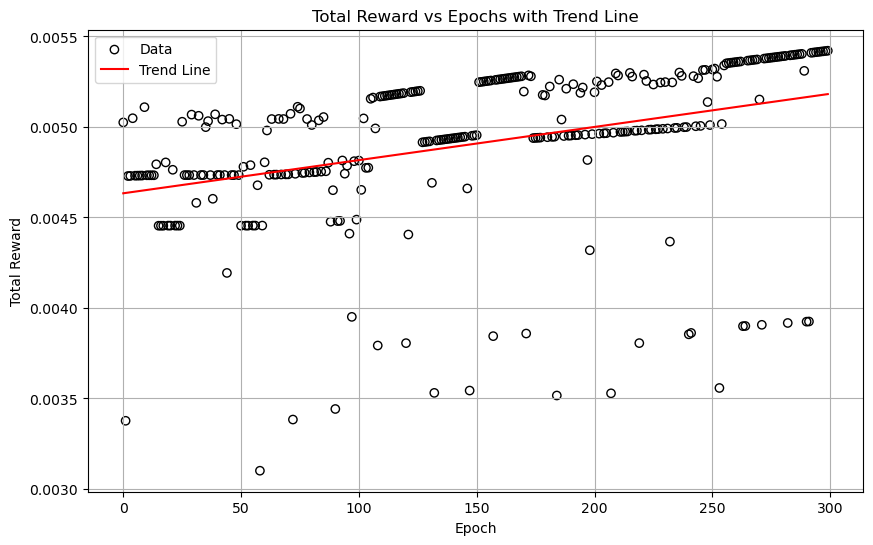

In [203]:
# Fit a linear regression line to all data points
x = np.arange(num_epochs)
m, b = np.polyfit(x, total_rewards, 1)

# Plot the data points as hollow circles and the trend line as a solid line
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(num_epochs), total_rewards, marker='o', facecolors='none', edgecolors='black', label='Data')
plt.plot(x, m*x + b, color='red', label='Trend Line')  # Plot the trend line

plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Epochs with Trend Line')
plt.legend()
plt.grid(True)
plt.show()

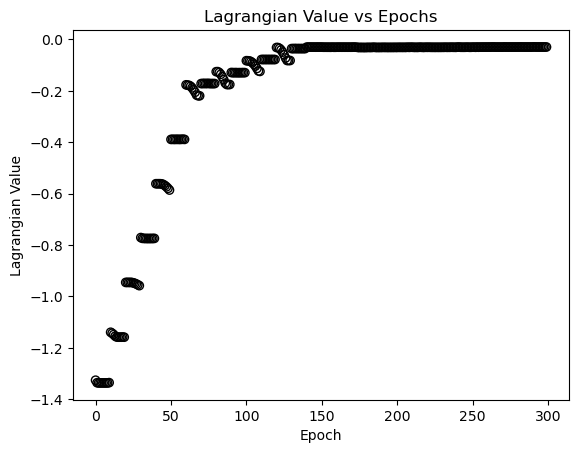

In [204]:
plt.scatter(range(num_epochs), lagrangian_values, marker='o',facecolors='none', edgecolors='black')
plt.xlabel('Epoch')
plt.ylabel('Lagrangian Value')
plt.title('Lagrangian Value vs Epochs')
plt.show()

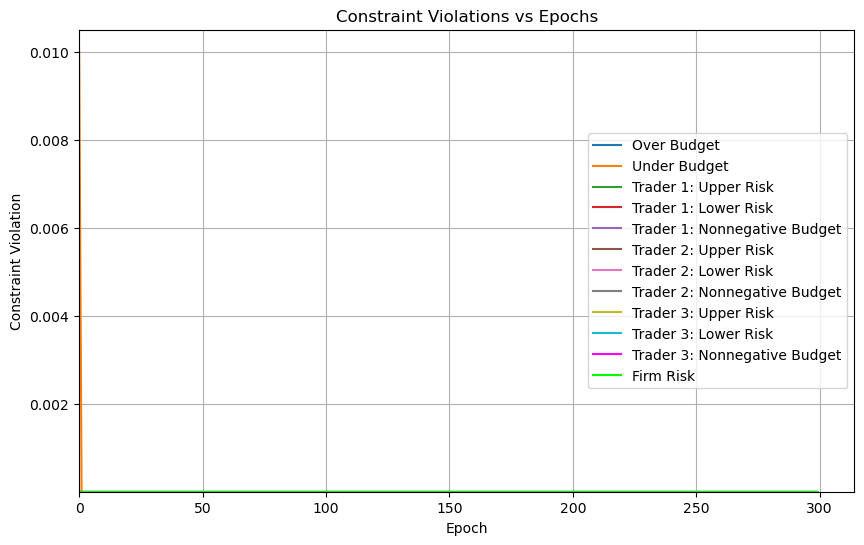

In [205]:
# Define the labels for constraint types
constraint_types = ['Over Budget', 'Under Budget'] + ['Upper Risk', 'Lower Risk', 'Nonnegative Budget'] * N + ['Firm Risk']
# Define a custom color cycle with 12 different colors
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
                 '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#ff00ff', '#00ff00']

plt.figure(figsize=(10, 6))

# Set the color cycle to the custom colors
plt.gca().set_prop_cycle('color', custom_colors)

constraint_violations_np = np.array(constraint_violations)

for i in range(constraint_violations_np.shape[1]):
    if i == 0 or i == 1 or i == constraint_violations_np.shape[1]-1:
        label = constraint_types[i]
    else:
        trader_number = (i - 2) // 3 + 1 # Calculate trader number from 1 to N
        constraint_type = constraint_types[i]
        label = f'Trader {trader_number}: {constraint_type}'

    plt.plot(range(num_epochs), constraint_violations_np[:, i], label=label)

# Set y-axis limits to start at 1e-5
plt.ylim(bottom=1e-5)
plt.xlim(left=0)

plt.xlabel('Epoch')
plt.ylabel('Constraint Violation')
plt.title('Constraint Violations vs Epochs')
plt.legend(loc='center right')
plt.grid(True)
plt.show()


In [206]:
constraint_violations

[[0.0, 0.00999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 5.9604645e-08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.1920929e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.1920929e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 5.9604645e-